# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    PolynomialFeatures, 
    LabelEncoder,
    StandardScaler, 
    MinMaxScaler, 
    OneHotEncoder, 
    KBinsDiscretizer
)
from sklearn.linear_model import (
    LinearRegression, 
    LogisticRegression,
    Ridge, 
    Lasso,
    ElasticNet
)
from sklearn.tree import (
    DecisionTreeRegressor,
    DecisionTreeClassifier
)
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier
)   
from sklearn.model_selection import (
    train_test_split,
    cross_val_predict,
    GridSearchCV,
)
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    confusion_matrix, 
    accuracy_score, 
    classification_report,
    recall_score,
    precision_score
)
from sklearn.feature_selection import SelectFromModel

from scripts.clean_dataset import clean_dataset
from scripts.helper import currency, cal_accuracy
from scripts.model_serializer import ModelSerializer

# Importing the cleaned dataset

In [2]:
df_train = pd.read_csv('data/Train_cleaned.csv')
#df_train = pd.read_csv('data/Train_cleaned_log_transformed.csv')

In [3]:
df_train.shape

(3917, 28)

In [4]:
#for col in df_train.columns:
#    print(df_train[col].value_counts())

## Categorization of total_cost (using KBins)

In [5]:
bin_names = ['Low', 'Medium', 'High']
#bin_names = ['Very low', 'Low', 'Medium', 'High', 'Very high']

kbins = KBinsDiscretizer(
    n_bins=len(bin_names),
    encode='onehot-dense', # onehot, onehoe-dense, ordinal
    strategy='quantile',   # kmeans, uniform, quantile
)
bin_data  = kbins.fit_transform(df_train[['total_cost_euro']])
#bin_data  = kbins.fit_transform(df_train[['total_cost_euro_log']])
bin_edges = kbins.bin_edges_[0].round()

# Apply pd.cut with custom bin edges to start the first bin at zero
bin_edges = np.concatenate(([0], bin_edges[1:]))

df_train['total_cost_category'] = pd.cut(
    df_train['total_cost_euro'], 
#    df_train['total_cost_euro_log'], 
    bins=bin_edges, 
    labels=bin_names, 
    include_lowest=True,
    right=False
)

### Class-Balance

In [6]:
df_train['total_cost_category'].value_counts(normalize=True)#.apply(lambda x: f"{round(x*100, 2)}%")

total_cost_category
Low       0.349247
High      0.333418
Medium    0.317335
Name: proportion, dtype: float64

In [7]:
# show the bins
for i in range(len(bin_names)):
    print(bin_names[i].ljust(11), currency(bin_edges[i]).rjust(11), " - ", currency(bin_edges[i+1]).rjust(11))

Low              0.00 €  -     605.00 €
Medium         605.00 €  -   2,848.00 €
High         2,848.00 €  -  36,330.00 €


# Target and Features

In [8]:
# Target:
y = df_train['total_cost_category']
#y = df_train['total_cost']
# Features:
X = df_train.drop([
    'total_cost', 'total_cost_euro', 'total_cost_category'#, 'total_cost_euro_log'
], axis=1)

## Seperate numerical and categorical features

In [9]:
num_features = list(X.select_dtypes(include=['number']).columns)
cat_features = list(X.select_dtypes(exclude=['number']).columns)

In [10]:
cat_features = list(set(cat_features) - set(['info_source', 'payment_mode', 'most_impressing', 'single_male', 'single_female']))
#num_features = ['total_travelers', 'night_zanzibar', 'night_mainland']
num_features = ['total_travelers', 'night_total']

In [11]:
cat_features, num_features

(['age_group',
  'first_trip_tz',
  'package_guided_tour',
  'travel_with',
  'package_food',
  'package_transport_tz',
  'purpose',
  'country',
  'main_activity',
  'package_accomodation',
  'package_transport_int',
  'tour_arrangement',
  'package_insurance',
  'package_sightseeing'],
 ['total_travelers', 'night_total'])

# Splitting the dataset

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=47)

# Baseline Model

Our baseline model is just using the median of all spendings.

In [13]:
print('Mean:  ', currency(df_train.total_cost_euro.mean()))
print('Median:', currency(df_train.total_cost_euro.median()))

Mean:   3,161.80 €
Median: 1,451.97 €


In [14]:
df_train.total_cost_euro.describe().apply(lambda x: currency(x))

count     3,917.00 €
mean      3,161.80 €
std       4,493.08 €
min          17.88 €
25%         344.84 €
50%       1,451.97 €
75%       3,932.42 €
max      36,329.50 €
Name: total_cost_euro, dtype: object

In [15]:
from sklearn.base import BaseEstimator, ClassifierMixin

class BaselineClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.majority_ = y.mode()
        return self
    
    def predict(self, X):
        return np.array(X.shape[0]*[self.majority_])

In [16]:
# build baseline model
baseline_model = BaselineClassifier()
baseline_model.fit(X_train, y_train)
baseline_score = baseline_model.score(X_train, y_train)
print("Accuracy of Baseline model:", round(baseline_score, 2))

Accuracy of Baseline model: 0.35


# Create a pipeline

## Building the pipeline

In [175]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler',  StandardScaler()),
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')) 
])

# Combine transformers into a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features),
])

# Create a Logistic Regression pipeline
estimator = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestClassifier())),
    ('classifier',   RandomForestClassifier(max_depth=18, min_samples_leaf=2, min_samples_split=3, n_estimators=60))
    #('classifier',   DecisionTreeClassifier(max_depth=18, min_samples_leaf=2, min_samples_split=4,  max_features='sqrt'))
])

estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_travelers',
                                                   'night_total']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_group', 'firs...
                                                   'package_transport_tz',
                                                   'purpose', 'country',
                                                   'main_activity',
                                                   'package_accomodation',
                                                   'package_transport_int',
                                                   'tour_arrangement',
                                                   'package_insurance',
                                                   'package_sightseeing'])])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier())),
                ('classifier',
                 RandomForestClassifier(max_depth=18, min_samples_leaf=2,
                                        min_samples_split=3,
                                        n_estimators=60))])

## Predicting

In [176]:
# Predict for training and test sets
y_pred_train = estimator.predict(X_train)
y_pred_test  = estimator.predict(X_test)

## Evaluation

### Training set evaluation

Accuracy on train set: 0.8
Accuracy on train set: 0.8
              precision    recall  f1-score   support

        High       0.78      0.89      0.83       914
         Low       0.83      0.83      0.83       957
      Medium       0.78      0.67      0.72       870

    accuracy                           0.80      2741
   macro avg       0.80      0.80      0.79      2741
weighted avg       0.80      0.80      0.80      2741



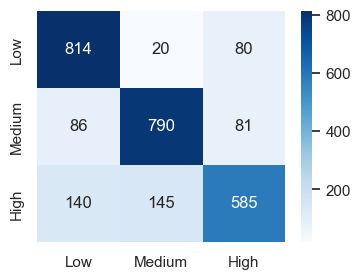

In [177]:
print("Accuracy on train set:", round(estimator.score(X_train, y_train), 2))
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))

print(classification_report(y_train, y_pred_train))

cf_train = confusion_matrix(y_train, y_pred_train)
sns.set(rc={"figure.figsize":(4, 3)})
sns.heatmap(cf_train, annot=True, fmt="", cmap='Blues', xticklabels=bin_names, yticklabels=bin_names);

### Test set evaluation

Accuracy on test set: 0.69
Accuracy on test set: 0.69
              precision    recall  f1-score   support

        High       0.70      0.82      0.75       392
         Low       0.75      0.75      0.75       411
      Medium       0.60      0.49      0.54       373

    accuracy                           0.69      1176
   macro avg       0.68      0.69      0.68      1176
weighted avg       0.69      0.69      0.68      1176



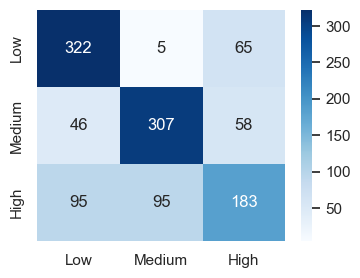

In [178]:
print("Accuracy on test set:", round(estimator.score(X_test,  y_test), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test), 2))

print(classification_report(y_test, y_pred_test))

cf_test = confusion_matrix(y_test, y_pred_test)
sns.set(rc={"figure.figsize":(4, 3)})
sns.heatmap(cf_test, annot=True, fmt="", cmap='Blues', xticklabels=bin_names, yticklabels=bin_names);

### Feature Importance

In [179]:
onehot_columns = list(estimator.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(cat_features))
feature_names = estimator.named_steps['preprocessor'].get_feature_names_out()
importance    = estimator.named_steps['classifier'].feature_importances_
feature_names = estimator.named_steps['feature_selection'].get_feature_names_out()
#feature_names = estimator.named_steps['feature_selection'].feature_names_in_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(10)

,Feature,Importance
1,x1,0.140471
0,x0,0.069110
19,x20,0.063890
35,x121,0.063629
40,x126,0.060832
10,x10,0.045960
16,x17,0.036136
36,x122,0.030493
39,x125,0.029114
14,x15,0.028536


## Cross Validation

In [181]:
y_pred_test_cv = cross_val_predict(estimator, X_test, y_test, cv=8)

In [182]:
cv_score = estimator.score(X_test, y_pred_test_cv)
print("Cross validation scores:", round(cv_score, 2))
print(classification_report(y_test, y_pred_test_cv))

Cross validation scores: 0.88
              precision    recall  f1-score   support

        High       0.68      0.79      0.73       392
         Low       0.74      0.73      0.73       411
      Medium       0.55      0.46      0.50       373

    accuracy                           0.66      1176
   macro avg       0.65      0.66      0.65      1176
weighted avg       0.66      0.66      0.66      1176



## Logistic Regression

Logistic regression is a classification algorithm that is suited for binary or multi-class classification problems, where the target variable is categorical.

In [183]:
estimator2 = Pipeline(steps=[
   ('preprocessor', preprocessor),
   ('feature_selection', SelectFromModel(RandomForestClassifier())),
   ('classifier',   LogisticRegression(max_iter=10_000, class_weight="balanced"))
])

estimator2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_travelers',
                                                   'night_total']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_group', 'firs...
                                                   'travel_with',
                                                   'package_food',
                                                   'package_transport_tz',
                                                   'purpose', 'country',
                                                   'main_activity',
                                                   'package_accomodation',
                                                   'package_transport_int',
                                                   'tour_arrangement',
                                                   'package_insurance',
                                                   'package_sightseeing'])])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier())),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=10000))])

In [184]:
# Predict for training and test sets
y_pred_train = estimator2.predict(X_train)
y_pred_test  = estimator2.predict(X_test)

In [185]:
print("Accuracy on train set:", round(estimator2.score(X_train, y_train), 2))
print("Accuracy on train set:", round(estimator2.score(X_test, y_test), 2))

Accuracy on train set: 0.7
Accuracy on train set: 0.68


# Grid Search

In [30]:
# Define a parameter grid for GridSearchCV
param_grid = {
    'classifier': [
        DecisionTreeClassifier(),
#        RandomForestClassifier(max_depth=7, n_estimators=70, min_samples_split=10),
#        GradientBoostingClassifier(),
    ],
#    'classifier__n_estimators': [10, 25, 50, 75, 100],
    'classifier__min_samples_split': [2,3,4,5,7,10],
    'classifier__max_depth': [2,3,4,5,6,8],
#    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
}

# Create GridSearchCV,
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=3, verbose=1) # scoring='neg_mean_squared_error', #'r2', 

# Fit the model
%timeit grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model   = grid_search.best_estimator_
best_params  = grid_search.best_params_

# Make predictions
y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Fitting 3 folds for each of 36 candidates, totalling 108 fits
1.94 s ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['total_travelers',
                                                   'night_total']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['age_group', 'first_trip_tz',
                                                   'package_guided_tour',
                                                   'travel_with',
                                                   'package_food',
                                                   'package_transport_tz',
                                                   'purpose', 'country',
                                                   'main_activity',
                                                   'package_accomodation',
                                                   'package_transport_int',
                                                   'tour_arrangement',
                                                   'package_insurance',
                                                   'package_sightseeing'])])),
                ('classifier', DecisionTreeClassifier(max_depth=3))])

In [32]:
best_params

{'classifier': DecisionTreeClassifier(max_depth=3),
 'classifier__max_depth': 3,
 'classifier__min_samples_split': 2}

In [33]:
print("Train score: ", round(best_model.score(X_train, y_train), 2))
print("Test score:  ", round(best_model.score(X_test,  y_test),  2))

Train score:  0.67
Test score:   0.67


# Saving the model

In [ ]:
ModelSerializer('models/best_model.sav').save(best_model)